# How to extract features from fMOST data with [neuron_morphology](https://github.com/AllenInstitute/neuron_morphology)

To obtain the package, please see [https://neuron-morphology.readthedocs.io/en/readthedocs/](https://neuron-morphology.readthedocs.io/en/readthedocs/).

This step-by-step guide will walk you through the process of extracting features from fMOST data.
* Load fMOST data from file
* Clean up swc to prevent errors
* Extract the neuron_morphology default_features
* Add a custom feature to calculate as well


In [1]:
import sys
sys.path.insert(0, "../")

from io import StringIO
import copy
import matplotlib.pyplot as plt

import neuron_morphology.swc_io as swcio
from neuron_morphology.morphology import Morphology
from neuron_morphology.swc_io import morphology_from_swc
from neuron_morphology.feature_extractor.data import Data
from neuron_morphology.feature_extractor.feature_extractor import FeatureExtractor
from neuron_morphology.features.default_features import default_features
from neuron_morphology.constants import (
    SOMA, AXON, BASAL_DENDRITE, APICAL_DENDRITE
)

import json
import numpy as np
import neuron_morphology.feature_extractor.feature_writer as fw

## Pick your neuron (.swc/.csv)

Here select one SWC file as an example.

In [2]:
fmost_swc_file = "../../tests/data/17545-6151-X24259-Y36270.swc"

## Ensure one SWC with only one soma point

This is developed for current registered fMOST SWC file. It will adjusted and added as a module into neuron_morphology later.

In [3]:
def prepare_neuron_tree(swc_data):
    nodes = swc_data.to_dict('record')

    replace_type = 2 # default node type
    for node in nodes:
        node['parent'] = int(node['parent'])
        node['id'] = int(node['id'])
        node['type'] = int(node['type'])

        if node['parent'] == -1 and node['type'] != 1:
            replace_type = node['type']

        if node['type'] == 1 and node['parent'] != -1:
            node['type'] = replace_type

    soma_list = []
    for node in nodes:
        if node['type'] == 1:
            soma_list.append(node)

    # create a new soma point
    if len(soma_list) > 1:
        x = 0
        y = 0
        z = 0
        n = len(soma_list)
        for node in soma_list:
            x += node['x']
            y += node['y']
            z += node['z']

        soma = copy.deepcopy(soma_list[0])
        soma['id'] = nodes[-1]['id']
        soma['x'] = x/n
        soma['y'] = y/n
        soma['z'] = z/n
        nodes.append(soma)

        for node in soma_list:
            node['parent'] = soma['id']
            node['type'] = replace_type
    
    return nodes

## Load SWC file as morphology data

We can load the SWC file into our morphology data object and then calculate features on it.

Text(0.5, 1.0, 'z-y view')

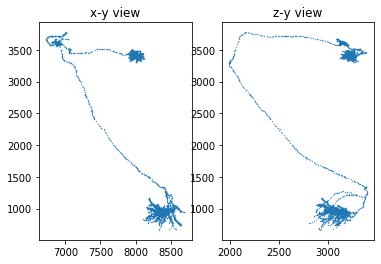

In [4]:
# load
swc_data = swcio.read_swc(fmost_swc_file)

nodes = prepare_neuron_tree(swc_data)
test_data = Data(Morphology(nodes, node_id_cb=lambda node: node['id'], parent_id_cb=lambda node: node['parent']))

# visualize
x = [node['x'] for node in nodes]
y = [node['y'] for node in nodes]
z = [node['z'] for node in nodes]

fig, ax = plt.subplots(1, 2)
ax[0].scatter(x, y, s=0.1)
ax[0].set_title('x-y view')
ax[1].scatter(z, y, s=0.1)
ax[1].set_title('z-y view')

## Define interested features set

First, we instantiate a FeatureExtractor
Second, we will use register the default_features

In [5]:
fe = FeatureExtractor()
fe.register_features(default_features)

Then, let's add a custom feature. We will use a feature included in the neurom_morphology package which calculates the number of stems exiting from the soma, by neurite type.

For reference, here is the entire function:

```
@marked(RequiresSoma)  
@marked(RequiresRoot) 
def calculate_number_of_stems(data: Data, node_types: Optional[List[int]]):

    """
        Calculate the number of soma stems.
        This is defined as the total number of non-soma child nodes on soma nodes.

        Parameters
        ----------
        data: Data Object containing a morphology

        node_types: list (AXON, BASAL_DENDRITE, APICAL_DENDRITE)
        Type to restrict search to

        Returns
        -------

        Scalar value

    """

    soma = data.morphology.get_soma()
    return len(data.morphology.children_of(soma))
```
This function has been marked to indicate that it needs a soma in order to be valid, and is also specializable based on node types. We will use the specialize() function and the NEURITE_SPECIALIZATION to tell the feature extractor to calculate this feature for each neurite_type (AXON, DENDRITE, BASAL_DENDRITE, APICAL_DENDRITE, ALL_NEURITES)

In [6]:
from neuron_morphology.features.soma import calculate_number_of_stems

from neuron_morphology.feature_extractor.marked_feature import specialize
from neuron_morphology.feature_extractor.feature_specialization import NEURITE_SPECIALIZATIONS

fe.register_features([specialize(calculate_number_of_stems, NEURITE_SPECIALIZATIONS)])

### Extracting features

Now that we have registered the features that we are interested in, we can call feature extractor on our swc. This will create a dictionary of results, which we can unnest and print below. 

Calling fe.extract() on another test_data will calculate the same feature set, so it can be used to process many swcs.

In [7]:
feature_extraction_run = fe.extract(test_data)
results = feature_extraction_run.results
from neuron_morphology.feature_extractor.utilities import unnest
unnest(results)


2020-02-25 13:13:47,771 root         INFO     skipping mark (validation failed): type
2020-02-25 13:13:47,773 root         INFO     skipping mark (validation failed): type
2020-02-25 13:13:47,774 root         INFO     skipping mark (validation failed): type
/Users/matthew.aitken/allen_dev/neuron_morphology/neuron_morphology/feature_extractor/mark.py:118: UserWarning: This morphology is not uniquely rooted! Found 279 root nodes. Features using the root node of this morphology may not select that node consistently. Some or all of these root nodes may not be soma nodes.
  f"This morphology is not uniquely rooted! Found {num_roots} "
2020-02-25 13:13:47,780 root         INFO     selected marks: <bound method FeatureExtractionRun.select_marks of <neuron_morphology.feature_extractor.feature_extraction_run.FeatureExtractionRun object at 0x1a25a2b358>>
2020-02-25 13:13:47,780 root         INFO     skipping feature: apical_dendrite.node.dimension. Found extra marks: ['RequiresApical']
2020-02-2

2020-02-25 13:13:47,824 root         INFO     skipping feature: axon.basal_dendrite.earth_movers_distance. Found extra marks: ['RequiresReferenceLayerDepths', 'RequiresLayeredPointDepths']
2020-02-25 13:13:47,825 root         INFO     skipping feature: apical_dendrite.basal_dendrite.earth_movers_distance. Found extra marks: ['RequiresReferenceLayerDepths', 'RequiresLayeredPointDepths', 'RequiresApical']
2020-02-25 13:13:47,826 root         INFO     skipping feature: apical_dendrite.calculate_number_of_stems. Found extra marks: ['RequiresApical']
2020-02-25 13:13:47,827 root         INFO     selected features: ['axon.node.dimension', 'all_neurites.node.dimension', 'dendrite.node.dimension', 'basal_dendrite.node.dimension', 'axon.tip.dimension', 'all_neurites.tip.dimension', 'dendrite.tip.dimension', 'basal_dendrite.tip.dimension', 'axon.compartment.dimension', 'all_neurites.compartment.dimension', 'dendrite.compartment.dimension', 'basal_dendrite.compartment.dimension', 'axon.bifurcatio

{'axon.node.dimension.width': 1967.175000000001,
 'axon.node.dimension.height': 3112.875,
 'axon.node.dimension.depth': 1416.8250000000003,
 'axon.node.dimension.min_xyz': array([ -194.125, -2929.8  , -1205.35 ]),
 'axon.node.dimension.max_xyz': array([1773.05 ,  183.075,  211.475]),
 'axon.node.dimension.bias_xyz': array([1578.925, 2746.725,  993.875]),
 'all_neurites.node.dimension.width': 1967.175000000001,
 'all_neurites.node.dimension.height': 3112.875,
 'all_neurites.node.dimension.depth': 1416.8250000000003,
 'all_neurites.node.dimension.min_xyz': array([ -194.125, -2929.8  , -1205.35 ]),
 'all_neurites.node.dimension.max_xyz': array([1773.05 ,  183.075,  211.475]),
 'all_neurites.node.dimension.bias_xyz': array([1578.925, 2746.725,  993.875]),
 'dendrite.node.dimension.width': 222.4250000000011,
 'dendrite.node.dimension.height': 201.60000000000127,
 'dendrite.node.dimension.depth': 196.77500000000055,
 'dendrite.node.dimension.min_xyz': array([ 967.7  , -284.375,  -72.85 ]),
 

##### Save the features as h5 or csv file

We can also write these features to a file using the FeatureWriter. The FeatureWriter can write the features as a nested json or as a flat csv. If a feature returns a large amount of data, it can be output to a h5 file instead.

In [8]:
heavy_path = "test_features.h5"
table_path = "test_features.csv"

features_writer = fw.FeatureWriter(heavy_path, table_path)
features_writer.add_run("test", feature_extraction_run.serialize())
features_writer.write_table()

/Users/matthew.aitken/allen_dev/neuron_morphology/neuron_morphology/feature_extractor/feature_writer.py:54: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  self.heavy_file = h5py.File(self.heavy_path, driver="core")
2020-02-25 13:13:49,879 root         WARNING  writing additional outputs to csv. See output json for record of selected features and marks
